In [24]:
import os
import torch
import torch.nn as nn
from matplotlib import pyplot as pyplot
from torch import optim
from tqdm import tqdm
from utils import *
import torch.nn.functional as F
import pdb

In [36]:
class Diffusion:
    def __init__(self, noise_steps = 1000, beta_start = 1e-4, beta_end = 0.02, img_size = 64, device = 'cpu'):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device
        pdb.set_trace()
        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_hat = torch.cumprod(self.alpha , dim = 0)

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)
    
    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        one_minus_alpha_hat = torch.sqrt(1-self.alpha_hat[t])[:, None, None, None]
        epsilon = torch.randn_like(x)
        return sqrt_alpha_hat*x + one_minus_alpha_hat * epsilon, epsilon
    
    def sample_timesteps(self, n):
        return torch.randint(low= 1, high = self.noise_steps, size=(n,))
    
    def sample(self, model, n):
        model.eval()
        with torch.no_grad():
            x = torch.randn((n , 3, self.img_size, self.img_size)). to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n)* i).long().to(self.device)
                predicted_noise = model(x, t)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1/ torch.sqrt(alpha) * (x - ((1-alpha) / (torch.sqrt(1-alpha_hat))) * predicted_noise) + torch.sqrt(beta) *  noise
        model.train()
        x = (x.clamp(-1, 1) + 1 ) / 2
        x = (x * 255.0).type(torch.uint8)
        return x

In [26]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)

In [27]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb

In [28]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb

In [29]:
class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)

In [30]:
class Unet(nn.Module):
    def __init__(self, in_channels= 3, out_channels = 3, time_dim = 256, device = 'cpu'):
        super(Unet, self).__init__()

        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128,32)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256,16)
        self.down3 = Down(256,256)
        self.sa3 = SelfAttention(256,8)

        self.bot1 = DoubleConv(256,512)
        self.bot2 = DoubleConv(512,512)
        self.bot3 = DoubleConv(512,256)

        self.up1 = Up(512,128)
        self.sa4 = SelfAttention(128,16)
        self.up2 = Up(256, 64)    
        self.sa5 = SelfAttention(64,32)   
        self.up3 = Up(128, 64)  
        self.sa6 = SelfAttention(64,64)  

        self.outc = nn.Conv2d(64, out_channels, kernel_size= 1)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output




In [37]:
def train(args):
    setup_logging(args.run_name)
    device = args.device
    dataloader = get_data(args)
    model = Unet().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=args.lr)
    mse = nn.MSELoss()
    diffusion = Diffusion(img_size=args.image_size, device=device)
    l = len(dataloader)

    for epoch in range(args.epochs):
        pbar = tqdm(dataloader)
        for i, (images, _) in enumerate(pbar):
            images = images.to(device)
            t = diffusion.sample_timesteps(images.shape[0]).to(device)
            x_t, noise = diffusion.noise_images(images, t)
            predicted_noise = model(x_t, t)
            loss = mse(noise, predicted_noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar.set_postfix(MSE=loss.item())

        sampled_images = diffusion.sample(model, n=images.shape[0])
        save_images(sampled_images, os.path.join("results", args.run_name, f"{epoch}.jpg"))
        torch.save(model.state_dict(), os.path.join("models", args.run_name, f"ckpt.pt"))

In [38]:
# def launch():
#     import argparse
#     parser = argparse.ArgumentParser()
#     args = parser.parse_args()
#     args.run_name = "DDPM_Uncondtional"
#     args.epochs = 500
#     args.batch_size = 12
#     args.image_size = 64
#     #args.dataset_path = r"C:\Users\dome\datasets\landscape_img_folder"
#     args.device = "cpu"
#     args.lr = 3e-4
#     train(args)

In [39]:
def launch():
    class Args:
        pass

    args = Args()
    args.run_name = "DDPM_Uncondtional"
    args.epochs = 1
    args.batch_size = 12
    args.image_size = 64
    args.dataset_path = r"/Users/mouzam/Downloads/Pics"
    args.device = "cpu"
    args.lr = 3e-4
    train(args)

In [41]:
launch()

> /var/folders/bv/qb2wlknx6rqbx7ysszyd83h40000gn/T/ipykernel_81588/3075732952.py(9)__init__()
      7         self.device = device
      8         pdb.set_trace()
----> 9         self.beta = self.prepare_noise_schedule().to(device)
     10         self.alpha = 1.0 - self.beta
     11         self.alpha_hat = torch.cumprod(self.alpha , dim = 0)

> /var/folders/bv/qb2wlknx6rqbx7ysszyd83h40000gn/T/ipykernel_81588/3075732952.py(10)__init__()
      8         pdb.set_trace()
      9         self.beta = self.prepare_noise_schedule().to(device)
---> 10         self.alpha = 1.0 - self.beta
     11         self.alpha_hat = torch.cumprod(self.alpha , dim = 0)
     12 

> /var/folders/bv/qb2wlknx6rqbx7ysszyd83h40000gn/T/ipykernel_81588/3075732952.py(11)__init__()
      9         self.beta = self.prepare_noise_schedule().to(device)
     10         self.alpha = 1.0 - self.beta
---> 11         self.alpha_hat = torch.cumprod(self.alpha , dim = 0)
     12 
     13     def prepare_noise_schedule(self):


999it [1:00:43,  3.65s/it]


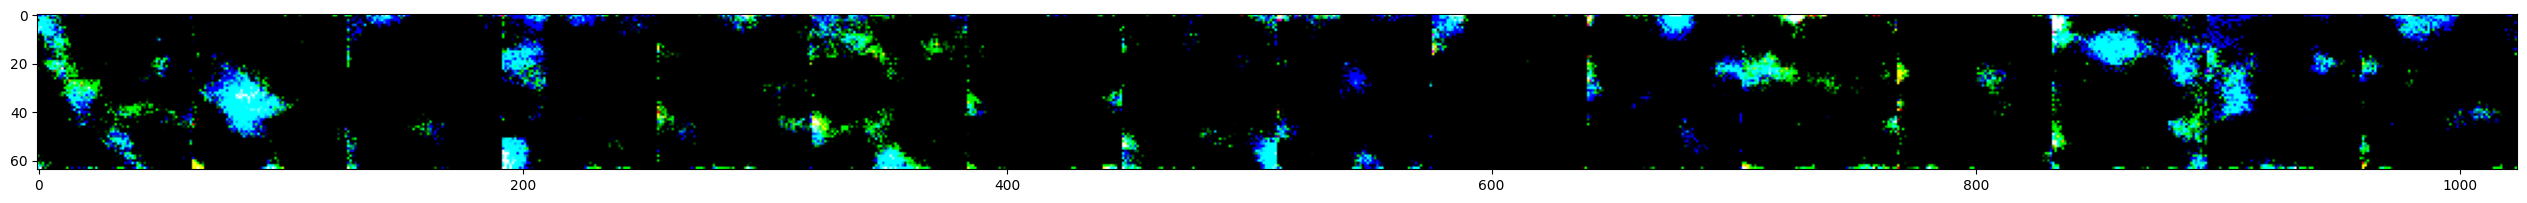

In [19]:
# device = "cpu"
# model = Unet().to(device)
# ckpt = torch.load(r"/Users/mouzam/TSAI/DiffusionModel/models/DDPM_Uncondtional/ckpt.pt")
# model.load_state_dict(ckpt)
# diffusion = Diffusion(img_size=64, device=device)
# x = diffusion.sample(model, n=16)
# plot_images(x)